In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.detection as detection
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertModel, BertTokenizer
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import json
import zipfile
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary
import pickle
import textwrap
import random

import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load Questions
def load_questions(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    questions = {q["question_id"]: {"image_id": q["image_id"], "question": q["question"]} for q in data["questions"]}
    return questions

# Load Annotations
def load_annotations(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    annotations = {}
    for ann in data["annotations"]:
        question_id = ann["question_id"]
        annotations[question_id] = {
            "answer": ann["multiple_choice_answer"],
            "answer_type": ann["answer_type"],
            "question_type": ann["question_type"]
        }
    return annotations

# Paths to JSON files
train_questions_path = "/kaggle/input/visual-based-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json"
val_questions_path = "/kaggle/input/visual-based-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json"
train_annotations_path = "/kaggle/input/visual-based-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json"
val_annotations_path = "/kaggle/input/visual-based-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json"

# Load data
train_questions = load_questions(train_questions_path)
val_questions = load_questions(val_questions_path)
train_annotations = load_annotations(train_annotations_path)
val_annotations = load_annotations(val_annotations_path)

In [4]:
# Merge Questions and Annotations
def merge_data(questions, annotations):
    merged_data = []
    for qid, q_data in questions.items():
        if qid in annotations:
            merged_data.append({**q_data, **annotations[qid]})
    return merged_data

train_data = merge_data(train_questions, train_annotations)
val_data = merge_data(val_questions, val_annotations)

# Convert to DataFrame
# Sample 100k from train_data
train_df = pd.DataFrame(train_data)

# Sample 50k from val_data
temp_df = pd.DataFrame(val_data)

print(f"train size: {len(train_df)}")
print(f"val size: {len(temp_df)}")

train size: 443757
val size: 214354


In [5]:
def save_vocab(vocab, file_path='vocab.pkl'):
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)
def load_vocab(file_path='vocab.pkl'):
    with open(file_path, 'rb') as f:
        vocab = pickle.load(f)
    return vocab

In [6]:
from collections import Counter

def build_answer_vocab(df, top_k=1000):
    answer_counter = Counter(df['answer'])  # Count occurrences
    most_common = answer_counter.most_common(top_k)

    answer2idx = {"<UNK>": 0}  # Unknown answers get index 0
    answer2idx.update({answer: i+1 for i, (answer, _) in enumerate(most_common)})
    idx2answer = {idx: answer for answer, idx in answer2idx.items()}

    return {"answer2idx": answer2idx, "idx2answer": idx2answer}


In [7]:
class VQADataset(Dataset):
    def __init__(self, data, image_folder, tokenizer, answer_vocab, transform=None, max_q_len=20):
        """
        data: DataFrame containing 'image_id', 'question', 'answer'
        image_folder: Path to images
        tokenizer: Pretrained BERT tokenizer
        answer_vocab: Dict mapping answers to indices
        transform: Image transformations
        max_q_len: Max question length for BERT
        """
        self.data = data
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.answer_vocab = answer_vocab  # Use predefined answer vocab
        self.transform = transform
        self.max_q_len = max_q_len  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Construct image path
        if "train" in self.image_folder.lower():
            img_path = f"{self.image_folder}/COCO_train2014_{int(row['image_id']):012d}.jpg"
        else:
            img_path = f"{self.image_folder}/COCO_val2014_{int(row['image_id']):012d}.jpg"

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize question using BERT tokenizer
        question_encoding = self.tokenizer(
            row['question'],
            padding="max_length",
            truncation=True,
            max_length=self.max_q_len,
            return_tensors="pt"
        )

        input_ids = question_encoding["input_ids"].squeeze(0)
        attention_mask = question_encoding["attention_mask"].squeeze(0)

        # Convert answer to index
        answer = self.answer_vocab["answer2idx"].get(row['answer'], self.answer_vocab["answer2idx"]["<UNK>"])

        return image, input_ids, attention_mask, torch.tensor(answer)


def collate_fn(batch):
    """
    Custom collate function to pad variable-length sequences properly.
    """
    images, input_ids, attention_masks, answers = zip(*batch)

    images = torch.stack(images, dim=0)  # Stack images into a batch

    # Pad sequences for `input_ids` and `attention_mask`
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    answers = torch.tensor(answers)

    return images, input_ids, attention_masks, answers


In [8]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Build answer vocabulary
answer_vocab = build_answer_vocab(train_df, top_k=10000)
save_vocab(answer_vocab,"answer_vocab.pkl")


# Split train-validation-test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=101)

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Small variation
    transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define image folder paths
train_folder="/kaggle/input/visual-based-question-answering/train2014/train2014"
val_folder="/kaggle/input/visual-based-question-answering/val2014/val2014"

# Instantiate datasets with tokenizer and answer vocab
train_dataset = VQADataset(train_df, image_folder=train_folder, 
                           tokenizer=tokenizer, answer_vocab=answer_vocab, 
                           transform=train_transform)
val_dataset = VQADataset(val_df, image_folder=val_folder, 
                         tokenizer=tokenizer, answer_vocab=answer_vocab, 
                         transform=transform)
test_dataset = VQADataset(test_df, image_folder=val_folder, 
                          tokenizer=tokenizer, answer_vocab=answer_vocab, 
                          transform=transform)

# Create dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, 
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, 
                        collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, 
                         collate_fn=collate_fn, num_workers=4, pin_memory=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        rcnn = detection.fasterrcnn_resnet50_fpn(pretrained=True)
        self.cnn = rcnn.backbone  # Extract ResNet backbone with FPN
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        
        # # Freeze all ResNet backbone layers except the last convolutional block (layer4)
        # for name, param in self.cnn.body.named_parameters():
        #     if "layer4" not in name:
        #         param.requires_grad = False

    def forward(self, images):
        # Extract feature map (B, 256, H, W)
        img_features = self.cnn(images)['0']  
        img_features = self.avgpool(img_features)  # (B, 256, 4, 4)
        img_features = img_features.flatten(2).permute(0, 2, 1)  # (B, 16, 256)
        return img_features


class MultiHeadAttentionModule(nn.Module):
    def __init__(self, img_feat_dim=256, q_feat_dim=2048, hidden_dim=1024, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        
        # Project image features into hidden space
        self.img_proj = nn.Linear(img_feat_dim, hidden_dim)  # (B, 16, hidden_dim)
        # Project question features into hidden space
        self.q_proj = nn.Linear(q_feat_dim, hidden_dim)

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        
        # Final projection layer
        self.fc_out = nn.Linear(hidden_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, img_features, q_features):
        """
        img_features: (B, 16, img_feat_dim) -> (B, 16, hidden_dim)
        q_features: (B, q_feat_dim) -> (B, 1, hidden_dim)
        """
        img_proj = self.img_proj(img_features)  # (B, 16, hidden_dim)
        q_proj = self.q_proj(q_features).unsqueeze(1)  # (B, 1, hidden_dim)
        
        # Apply multi-head attention
        attn_output, attn_weights = self.attention(q_proj, img_proj, img_proj)  # (B, 1, hidden_dim), (B, 1, 16)
        
        # Residual connection & layer norm
        attended_img = self.norm(attn_output + q_proj).squeeze(1)  # (B, hidden_dim)
        
        return self.fc_out(attended_img), attn_weights.squeeze(1)  # (B, hidden_dim), (B, 16)


class BertQuestionEncoder(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased"):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        # Freeze the first 6 layers of BERT's encoder
        for i, layer in enumerate(self.bert.encoder.layer):
            if i < 6:
                for param in layer.parameters():
                    param.requires_grad = False

        self.fc_q = nn.Sequential(
            nn.Linear(768, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 768),  # Output to match new attention module's q_feat_dim
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

    def forward(self, input_ids, attention_mask):
        # Get the CLS token embedding
        q_embed = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]  
        return self.fc_q(q_embed)


class VQAModel(nn.Module):
    def __init__(self, ans_vocab_size):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.question_encoder = BertQuestionEncoder()
        self.attention_module = MultiHeadAttentionModule(img_feat_dim=256, q_feat_dim=768, hidden_dim=1024, num_heads=8)
        
        # Fusion: Project attended image features and question features to a common space
        self.img_fusion_proj = nn.Linear(1024, 512)
        self.q_fusion_proj = nn.Linear(768, 512)
        self.fusion = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc_final = nn.Linear(1024, ans_vocab_size)

    def forward(self, images, input_ids, attention_mask):
        img_features = self.image_encoder(images)
        q_features = self.question_encoder(input_ids, attention_mask)
        attended_img, attn_weights = self.attention_module(img_features, q_features)
        
        # Fusion instead of concatenation:
        # Project both features to a common 512-d space
        img_fused = self.img_fusion_proj(attended_img)
        q_fused = self.q_fusion_proj(q_features)
        # Element-wise multiplication fusion
        fused = img_fused * q_fused
        fused = self.fusion(fused)
        
        return self.fc_final(fused)



In [10]:
ans_vocab_size = len(answer_vocab)
model = VQAModel(ans_vocab_size)
model.to("cpu")  # Ensure the model is on CPU

# Create sample input data
batch_size = 20
# Random image tensor with batch size 20 and image shape (3, 224, 224)
images = torch.randn(batch_size, 3, 224, 224)

# Define a sample question text
sample_question = "What is in the image?"
# Tokenize the sample question using BERT tokenizer
encoded = tokenizer(
    sample_question, 
    padding="max_length", 
    truncation=True, 
    max_length=20, 
    return_tensors="pt"
)
# Expand the question inputs to have the same batch size
input_ids = encoded["input_ids"].expand(batch_size, -1)
attention_mask = encoded["attention_mask"].expand(batch_size, -1)

# Run a forward pass with the sample inputs
output = model(images, input_ids, attention_mask)

# Print model summary with sample input data
summary(model, input_data=[images, input_ids, attention_mask], device="cpu")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 183MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Layer (type:depth-idx)                                            Output Shape              Param #
VQAModel                                                          [20, 2]                   --
├─ImageEncoder: 1-1                                               [20, 16, 256]             --
│    └─BackboneWithFPN: 2-1                                       [20, 256, 4, 4]           --
│    │    └─IntermediateLayerGetter: 3-1                          [20, 2048, 7, 7]          23,454,912
│    │    └─FeaturePyramidNetwork: 3-2                            [20, 256, 4, 4]           3,344,384
│    └─AdaptiveAvgPool2d: 2-2                                     [20, 256, 4, 4]           --
├─BertQuestionEncoder: 1-2                                        [20, 768]                 --
│    └─BertModel: 2-3                                             [20, 768]                 --
│    │    └─BertEmbeddings: 3-3                                   [20, 20, 768]             23,837,184
│    │    └─BertEncode

In [11]:
def train_loop(model, train_loader,scaler, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, input_ids, attention_masks, answers in tqdm(train_loader, desc="Training", leave=False):
        images, input_ids, attention_masks, answers = (
            images.to(device), input_ids.to(device), attention_masks.to(device), answers.to(device)
        )

        optimizer.zero_grad()
        
        # Forward pass (now includes attention mask)
        with torch.cuda.amp.autocast():
            outputs = model(images, input_ids, attention_masks)  
            loss = criterion(outputs, answers)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == answers).sum().item()
        total_samples += answers.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy
    
def val_loop(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, input_ids, attention_masks, answers in tqdm(val_loader, desc="Validating", leave=False):
            images, input_ids, attention_masks, answers = (
                images.to(device), input_ids.to(device), attention_masks.to(device), answers.to(device)
            )

            outputs = model(images, input_ids, attention_masks)
            loss = criterion(outputs, answers)

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == answers).sum().item()
            total_samples += answers.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [12]:
# Initialize model
ans_vocab_size = len(answer_vocab["answer2idx"])
model=torch.load("/kaggle/input/vqa-rcnn-bert/best_model.pth")
model = torch.nn.DataParallel(model)
model.to(device)

num_epochs = 5
save_every = 3  # Save model every 5 epochs
patience = 5  # Early stopping patience

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

In [13]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float("inf")
early_stop_counter = 0

#  Training Loop
for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_loop(model, train_loader, scaler, optimizer, criterion, device)
    val_loss, val_acc = val_loop(model, val_loader, criterion, device)

    # 🔹 Store Metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # 🔹 Learning Rate Scheduler Step
    scheduler.step()

    # 🔹 Save Model Every 4 Epochs
    if (epoch + 1) % save_every == 0:
        torch.save(model.module, f"model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}!")

    # 🔹 Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.module, "best_model.pth")
        torch.save(model.module.state_dict(), "best_model_state.pth")
        print(" best model saved!")
        early_stop_counter = 0  # Reset counter if validation loss improves
    else:
        early_stop_counter += 1  # Increment counter if no improvement

    if early_stop_counter >= patience:
        print("Early stopping triggered! Training stopped.")
        break

print("Training complete!")


 Epoch 1/5


Train Loss: 1.7865 | Train Acc: 0.5065
Val Loss: 2.0219 | Val Acc: 0.4765
 best model saved!

 Epoch 2/5


Train Loss: 1.7401 | Train Acc: 0.5182
Val Loss: 2.0160 | Val Acc: 0.4788
 best model saved!

 Epoch 3/5


Train Loss: 1.6765 | Train Acc: 0.5312
Val Loss: 2.0210 | Val Acc: 0.4796
Model saved at epoch 3!

 Epoch 4/5


Train Loss: 1.6059 | Train Acc: 0.5472
Val Loss: 2.0409 | Val Acc: 0.4845

 Epoch 5/5


Train Loss: 1.5435 | Train Acc: 0.5610
Val Loss: 2.0479 | Val Acc: 0.4851
Training complete!


In [14]:
# Store results for later analysis
training_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies
}

# Save training metrics to a file
with open("training_metrics.pkl", "wb") as f:
    pickle.dump(training_metrics, f)
print("📊 Training metrics saved!")

📊 Training metrics saved!


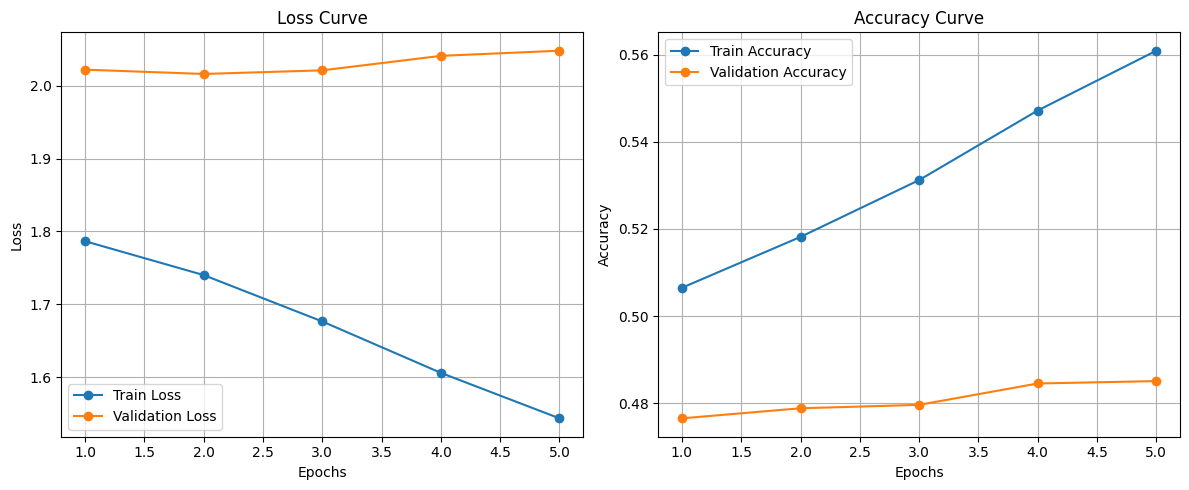

In [15]:
epochs = range(1, len(train_losses) + 1)

# 🔹 Plot Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

# 🔹 Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [16]:
model.eval()
# Store predictions & actual labels by category
category_results = {}
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch_idx, (images, input_ids, attention_masks, answers) in tqdm(
        enumerate(test_loader), total=len(test_loader), desc="Evaluating"
    ):
        images, input_ids, attention_masks, answers = (
            images.to(device), input_ids.to(device), attention_masks.to(device), answers.to(device)
        )

        # Model prediction
        outputs = model(images, input_ids, attention_masks)
        predicted_answers = outputs.argmax(dim=1)  # Get predicted indices for batch

        # **Batch-wise answer types & true labels**
        batch_start = batch_idx * test_loader.batch_size
        batch_end = min(batch_start + test_loader.batch_size, len(test_dataset.data))

        batch_answer_types = test_dataset.data.iloc[batch_start:batch_end]["answer_type"].tolist()
        batch_true_answers = test_dataset.data.iloc[batch_start:batch_end]["answer"].tolist()

        # Iterate over batch
        for idx in range(len(images)):  
            a_type = batch_answer_types[idx]  # Get corresponding answer type
            true_ans = batch_true_answers[idx]  # Get true answer
            pred_ans = answer_vocab["idx2answer"][predicted_answers[idx].item()]  # Convert index to text

            # Store results per category
            if a_type not in category_results:
                category_results[a_type] = {"correct": 0, "total": 0}

            category_results[a_type]["total"] += 1
            total_samples += 1  # Track total samples

            if true_ans == pred_ans:
                category_results[a_type]["correct"] += 1
                total_correct += 1  # Track total correct predictions

# 🔹 Print Category-wise Accuracy
print("\n **Category-wise Accuracy:**")
print("=" * 50)
for a_type, data in category_results.items():
    acc = (data["correct"] / data["total"]) * 100
    print(f" **Answer Type:** {a_type}")
    print(f" Accuracy: {acc:.2f}% ({data['correct']}/{data['total']})")
    print("-" * 50)

# 🔹 Compute & Print Overall Accuracy
overall_accuracy = (total_correct / total_samples) * 100
print("\n **Overall Accuracy:**")
print("=" * 50)
print(f" **Total Accuracy:** {overall_accuracy:.2f}% ({total_correct}/{total_samples})")
print("=" * 50)


Evaluating: 100%|██████████| 419/419 [08:24<00:00,  1.20s/it]


 **Category-wise Accuracy:**
 **Answer Type:** other
 Accuracy: 36.86% (19542/53011)
--------------------------------------------------
 **Answer Type:** yes/no
 Accuracy: 62.91% (25187/40038)
--------------------------------------------------
 **Answer Type:** number
 Accuracy: 29.76% (4205/14128)
--------------------------------------------------

 **Overall Accuracy:**
 **Total Accuracy:** 45.66% (48934/107177)


In [17]:
model=torch.load("/kaggle/input/vqa-rcnn-bert/best_model.pth")
model.to(device)
answer_vocab = load_vocab('answer_vocab.pkl')

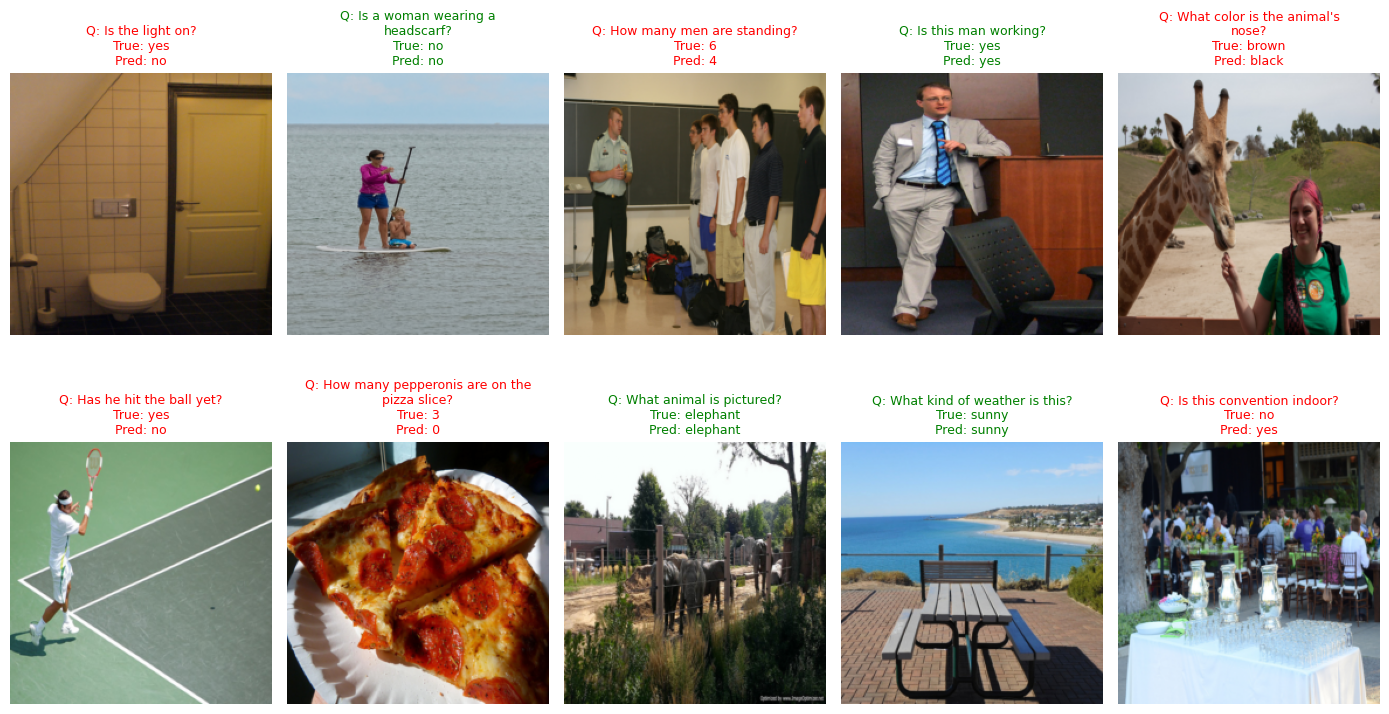

In [18]:
# ImageNet mean and std for denormalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)  
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)  
random.seed(101)
model.eval()

# Select 10 random samples from test_df
num_samples = 10
random_indices = random.sample(range(len(test_df)), num_samples)  # Random indices
selected_data = test_df.iloc[random_indices]  # Get corresponding rows

# Prepare tensors for model input
images, input_ids, attention_masks, question_texts, true_answers = [], [], [], [], []

for _, row in selected_data.iterrows():
    # Load and transform image
    if "train" in test_dataset.image_folder.lower():
        img_path = f"{test_dataset.image_folder}/COCO_train2014_{int(row['image_id']):012d}.jpg"
    else:
        img_path = f"{test_dataset.image_folder}/COCO_val2014_{int(row['image_id']):012d}.jpg"

    image = Image.open(img_path).convert('RGB')
    if test_dataset.transform:
        image = test_dataset.transform(image)
    
    # Encode question using tokenizer
    encoded_question = test_dataset.tokenizer(
        row['question'], 
        padding="max_length", 
        truncation=True, 
        max_length=test_dataset.max_q_len, 
        return_tensors="pt"
    )

    # Store question texts & true answers
    question_texts.append(row['question'])
    true_answers.append(row["answer"])

    # Append tensors
    images.append(image)
    input_ids.append(encoded_question["input_ids"].squeeze(0))  # Remove batch dim
    attention_masks.append(encoded_question["attention_mask"].squeeze(0))

# Convert lists to tensors
images = torch.stack(images).to(device)
input_ids = torch.stack(input_ids).to(device)
attention_masks = torch.stack(attention_masks).to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images, input_ids, attention_masks)
    predicted_answers_idx = outputs.argmax(dim=1)

# Plot setup (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(14, 8))

for idx in range(num_samples):
    row, col = divmod(idx, 5)  

    # Convert predicted answer index to text
    pred_answer = answer_vocab['idx2answer'].get(predicted_answers_idx[idx].item(), "Unknown Answer")

    # Wrap question text for better readability
    wrapped_question = "\n".join(textwrap.wrap(question_texts[idx], width=30))

    # Denormalize the image
    img_denorm = images[idx].unsqueeze(0) * std + mean  
    img_denorm = torch.clamp(img_denorm, 0, 1).squeeze(0)  

    # Color the predicted answer
    color = "green" if pred_answer == true_answers[idx] else "red"
    
    # Display image
    axes[row, col].imshow(img_denorm.cpu().permute(1, 2, 0).numpy())  
    axes[row, col].set_title(f"Q: {wrapped_question}\n"
                             f"True: {true_answers[idx]}\n"
                             f"Pred: {pred_answer}", 
                             fontsize=9, color=color)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


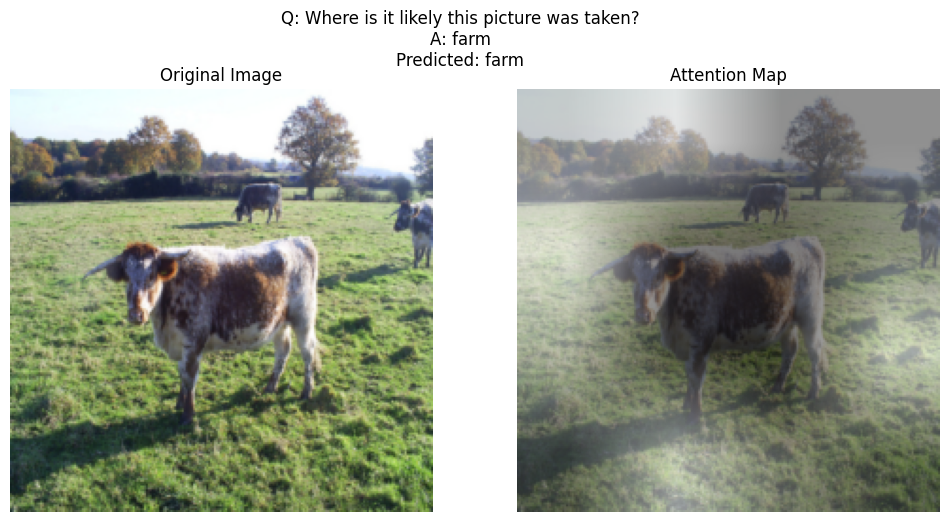

In [19]:
# Image folder path
folder_path = "/kaggle/input/visual-based-question-answering/val2014/val2014"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Denormalization tensors
mean_tensor = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

model.eval()

# Select a random sample
random.seed(69)
idx = random.choice(range(len(test_df)))
row = test_df.iloc[idx]
img_path = f"{folder_path}/COCO_val2014_{int(row['image_id']):012d}.jpg"

# Load and transform image
with Image.open(img_path) as img:
    image = img.convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Encode question using tokenizer
encoded_question = test_dataset.tokenizer(
    row['question'], 
    padding="max_length", 
    truncation=True, 
    max_length=test_dataset.max_q_len, 
    return_tensors="pt"
)

input_ids = encoded_question["input_ids"].to(device)
attention_mask = encoded_question["attention_mask"].to(device)

# Store true answer and question text
true_answer, question_text = row["answer"], row["question"]

with torch.no_grad():
    img_features = model.image_encoder(image_tensor)  # (B, 16, 256)
    q_features = model.question_encoder(input_ids, attention_mask)  # (B, 2048)

    # Get attended image features and attention weights
    attended_img, attn_weights = model.attention_module(img_features, q_features)  # (B, 1024), (B, 16)
    
    # Final output prediction
    output = model(image_tensor, input_ids, attention_mask)
    predicted_answer = answer_vocab['idx2answer'].get(output.argmax(dim=1).item(), "Unknown Answer")

# Denormalize image
img_denorm = torch.clamp(image_tensor * std_tensor + mean_tensor, 0, 1).squeeze(0).cpu().numpy()
img_denorm = np.transpose(img_denorm, (1, 2, 0))  # Convert to HWC format

# Reshape attention map (from 16 features to 4x4 grid)
attn_map = attn_weights.view(1, 1, 4, 4)  # (1, 1, 4, 4)

# Upscale attention map to 224x224
attn_map = F.interpolate(attn_map, size=(224, 224), mode="bilinear", align_corners=False).squeeze().cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize

# Plot Original Image + Attention Map
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(img_denorm)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Attention Overlay
axes[1].imshow(img_denorm)
axes[1].imshow(attn_map, cmap="gray", alpha=0.6)
axes[1].set_title("Attention Map")
axes[1].axis("off")

plt.suptitle(f"Q: {question_text}\nA: {true_answer}\nPredicted: {predicted_answer}", fontsize=12)
plt.show()



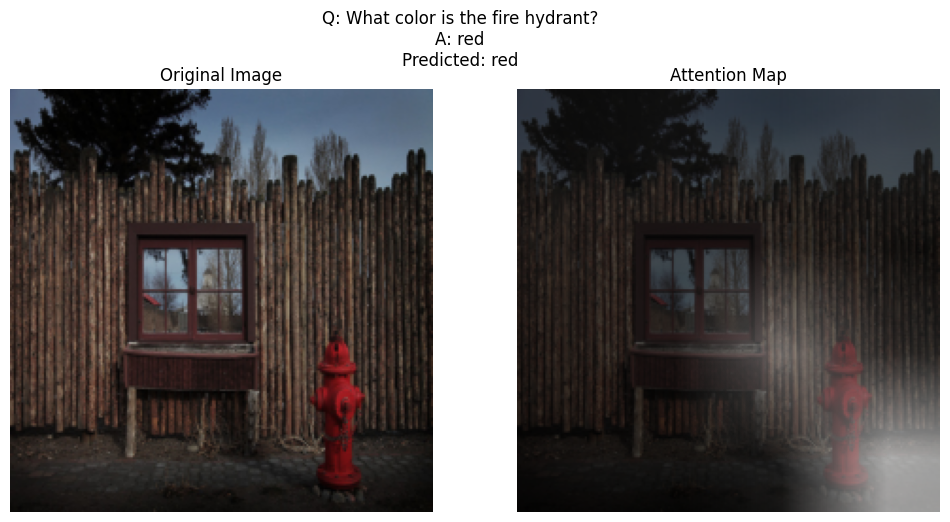

In [20]:
# Image folder path
folder_path = "/kaggle/input/visual-based-question-answering/val2014/val2014"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Denormalization tensors
mean_tensor = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

model.eval()

idx = 138921
row = test_df.loc[idx]
img_path = f"{folder_path}/COCO_val2014_{int(row['image_id']):012d}.jpg"

# Load and transform image
with Image.open(img_path) as img:
    image = img.convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Encode question using tokenizer
encoded_question = test_dataset.tokenizer(
    row['question'], 
    padding="max_length", 
    truncation=True, 
    max_length=test_dataset.max_q_len, 
    return_tensors="pt"
)

input_ids = encoded_question["input_ids"].to(device)
attention_mask = encoded_question["attention_mask"].to(device)

# Store true answer and question text
true_answer, question_text = row["answer"], row["question"]

with torch.no_grad():
    img_features = model.image_encoder(image_tensor)  # (B, 16, 256)
    q_features = model.question_encoder(input_ids, attention_mask)  # (B, 2048)

    # Get attended image features and attention weights
    attended_img, attn_weights = model.attention_module(img_features, q_features)  # (B, 1024), (B, 16)
    
    # Final output prediction
    output = model(image_tensor, input_ids, attention_mask)
    predicted_answer = answer_vocab['idx2answer'].get(output.argmax(dim=1).item(), "Unknown Answer")

# Denormalize image
img_denorm = torch.clamp(image_tensor * std_tensor + mean_tensor, 0, 1).squeeze(0).cpu().numpy()
img_denorm = np.transpose(img_denorm, (1, 2, 0))  # Convert to HWC format

# Reshape attention map (from 16 features to 4x4 grid)
attn_map = attn_weights.view(1, 1, 4, 4)  # (1, 1, 4, 4)

# Upscale attention map to 224x224
attn_map = F.interpolate(attn_map, size=(224, 224), mode="bilinear", align_corners=False).squeeze().cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize

# Plot Original Image + Attention Map
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(img_denorm)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Attention Overlay
axes[1].imshow(img_denorm)
axes[1].imshow(attn_map, cmap="gray", alpha=0.6)
axes[1].set_title("Attention Map")
axes[1].axis("off")

plt.suptitle(f"Q: {question_text}\nA: {true_answer}\nPredicted: {predicted_answer}", fontsize=12)
plt.show()

